In [ ]:
def timing_bars(run_timing_list,motion, motion_thresh, BOLD_window, subjid, timepoint, behavior_dir):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    
    from pandas import DataFrame,Series,read_table,concat
    from os.path import abspath
     
    # Import and organize motion data
    motion_df = read_table(motion,delim_whitespace=True,header=None)
    mean_translation = motion_df[[3,4,5]].mean(axis=1)
    
    # Create full task dataframe
    run_timing_list = sorted(run_timing_list)
    dfs = [ read_table(i,delim_whitespace=True) for i in run_timing_list ]
    k=1
    for df in dfs:
        df.loc[:,'runNum'] = Series(k, index = df.index)
        df.loc[:,'time_hyp'] = (k-1)*453 + df.loc[:,'time_hyp']
        df.loc[:,'trial'] = (k*100) + df.loc[:,'trial']
        k = k+1
    df_full = concat(dfs,ignore_index=True)
    df_full = df_full.sort(['runNum','time_hyp'], ascending=[1,1])
    df_full.loc[:,'motion'] = mean_translation
    df_full.loc[:,'subjid'] = Series(subjid,index=df_full.index)
    df_full.loc[:,'timepoint'] = Series(timepoint,index=df_full.index)
    
    # Sort out trials that are complete
    df_complete = df_full[df_full.loc[:,'catch']==0]
    
    # Add additional label to the trials with high motion
    df_complete.loc[:,'mot_cat'] = Series('low',index=df_complete.index)
    for index, row in df_complete.iterrows():
        hrf_length = index+BOLD_window
        trial_motion = df_full.iloc[index:hrf_length,8]
        excess_vols = (trial_motion >= motion_thresh) + (trial_motion <= (-1*motion_thresh))
        if sum(excess_vols) >= 3:
            df_complete.loc[index,'mot_cat'] = 'high'
    
    #df_complete.to_csv(behavior_dir + str(subjid) + '_cleaned_behavioral_data.csv')

    df_trials = df_complete[df_complete.loc[:,'stim']=='cue']
    df_usabletrials = df_trials[df_trials.loc[:,'mot_cat']=='low']
    df_usabletrials = df_usabletrials[df_usabletrials.loc[:,'lat'] > 0]
    
        
    return(df_usabletrials)

In [ ]:
from pandas import DataFrame, Series
import matplotlib.pyplot as plt 
from glob import glob

#analysis_home = '/Users/catcamacho/Box/LNCD_rewards_connectivity'
analysis_home = '/Volumes/Zeus/Cat'
#raw_dir = analysis_home + '/subjs'
raw_dir = '/Volumes/Phillips/bars/APWF_bars/subjs'
behavior_dir = analysis_home + '/proc/behavior/'
motion_dir = analysis_home + '/proc/preprocessing/motion_params'

#pull subject info to iter over
subject_info = DataFrame.from_csv(analysis_home + '/misc/subjs.csv')
subjects_list = subject_info['SubjID'].tolist()
timepoints = subject_info['Timepoint'].tolist()

#subjects_list = [10766]
#timepoints = [1]
motion_thresh = 0.9
BOLD_window = 8

summary_data = DataFrame()
summary_data.loc[:,'subjid'] = Series(subjects_list,index=None)
summary_data.loc[:,'timepoint'] = Series(timepoints,index=summary_data.index)
summary_data = summary_data.reindex(columns= summary_data.columns.tolist() + 
                                    ['num_use_total','lat_total','lat_total_std','num_use_neut',
                                     'mean_lat_neut','std_lat_neut','num_use_pun','mean_lat_pun',
                                     'std_lat_pun','mot_all','mot_pun','mot_neut'])

for subjid in subjects_list:
    sub_index = summary_data[summary_data['subjid']==subjid].index[0]
    timepoint = timepoints[subjects_list.index(subjid)]
    motion = motion_dir + '/%d_t%d/allmotion.txt' % (subjid,timepoint)
    run_timing_list = glob(raw_dir + '/%d/%d_*/timing/*score_timing.txt'% (subjid,timepoint))
    
    subject_df = timing_bars(run_timing_list,motion, motion_thresh, BOLD_window, subjid, timepoint, behavior_dir)
    sub_neut = subject_df[subject_df['cond'] == 'neutral']
    sub_pun = subject_df[subject_df['cond'] == 'punish']
    
    summary_data.loc[sub_index,'num_use_total'] = subject_df.shape[0]
    summary_data.loc[sub_index,'lat_total'] = subject_df['lat'].mean()
    summary_data.loc[sub_index,'lat_total_std'] = subject_df['lat'].std()
    summary_data.loc[sub_index,'num_use_neut'] = sub_neut.shape[0]
    summary_data.loc[sub_index,'mean_lat_neut'] = sub_neut['lat'].mean()
    summary_data.loc[sub_index,'std_lat_neut'] = sub_neut['lat'].std()
    summary_data.loc[sub_index,'num_use_pun'] = sub_pun.shape[0]
    summary_data.loc[sub_index,'mean_lat_pun'] = sub_pun['lat'].mean()
    summary_data.loc[sub_index,'std_lat_pun'] = sub_pun['lat'].std()
    summary_data.loc[sub_index,'mot_pun'] = sub_pun['motion'].mean()
    summary_data.loc[sub_index,'mot_neut'] = sub_neut['motion'].mean()
    summary_data.loc[sub_index,'mot_all'] = subject_df['motion'].mean()
    
summary_data.to_csv(behavior_dir + 'fullsample_means.csv')


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


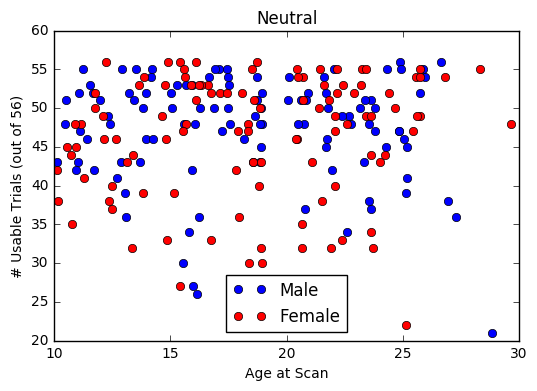

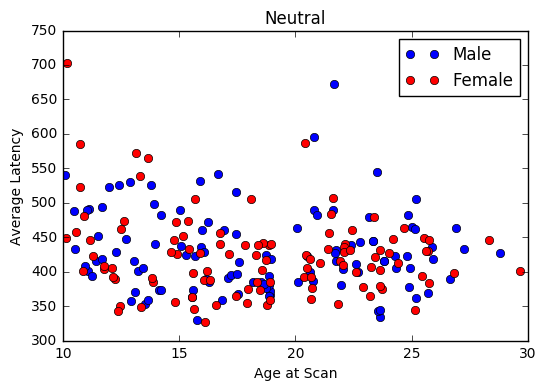

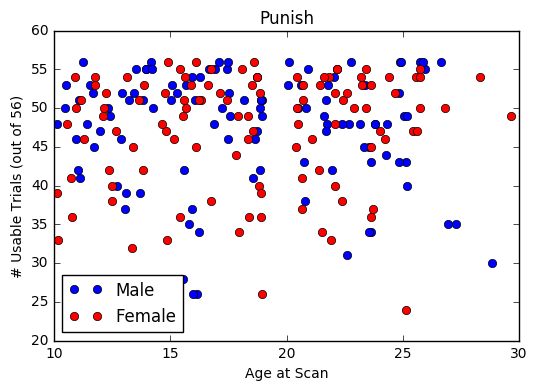

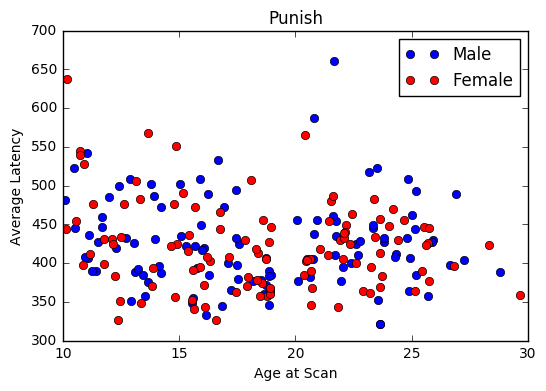

In [1]:
import matplotlib.pyplot as plt 
from pandas import DataFrame, Series,read_csv
analysis_home = '/Users/catcamacho/Box/LNCD_rewards_connectivity'
subject_info = read_csv(analysis_home + '/doc/fullsample_means.csv', index_col=0)


males = subject_info[subject_info.loc[:,'Male']==1]
females = subject_info[subject_info.loc[:,'Male']==0]

plt.plot(males['age'].tolist(),males['num_use_neut'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['num_use_neut'].tolist(),'ro', label='Female')
plt.legend(loc='best')
plt.xlabel('Age at Scan')
plt.ylabel('# Usable Trials (out of 56)')
plt.title('Neutral')
plt.savefig('neutral_trials.svg')
plt.show()

plt.plot(males['age'].tolist(),males['mean_lat_neut'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['mean_lat_neut'].tolist(),'ro', label='Female')
plt.legend(loc='best')
plt.xlabel('Age at Scan')
plt.ylabel('Average Latency')
plt.title('Neutral')
plt.savefig('neutral_lat.svg')
plt.show()

plt.plot(males['age'].tolist(),males['num_use_pun'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['num_use_pun'].tolist(),'ro', label='Female')
#plt.scatter(females['age'].tolist(),females['lat_total'])
plt.legend(loc='best')
plt.xlabel('Age at Scan')
plt.ylabel('# Usable Trials (out of 56)')
plt.title('Punish')
plt.savefig('punish_trials.svg')
plt.show()

plt.plot(males['age'].tolist(),males['mean_lat_pun'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['mean_lat_pun'].tolist(),'ro', label='Female')
plt.legend(loc='best')
plt.xlabel('Age at Scan')
plt.ylabel('Average Latency')
plt.title('Punish')
plt.savefig('punish_lat.svg')
plt.show()



In [ ]:
import matplotlib.pyplot as plt 
from pandas import DataFrame, Series,read_excel
analysis_home = '/Users/catcamacho/Box/LNCD_rewards_connectivity'
subject_info = read_excel(analysis_home + '/doc/groupsworksheet.xlsx')

males = subject_info[subject_info.loc[:,'Male']==1]
females = subject_info[subject_info.loc[:,'Female']==1]
male_age = males['age'].tolist()
female_age = females['age'].tolist()

fig1 = plt.hist([male_age, female_age], bins=20, stacked=True, align='mid', color=['blue','red'], label=['Male','Female'])
plt.xlabel('Age at Scan')
plt.ylabel('Number of Subjects')
plt.legend()
#plt.savefig('agehist.svg')
#plt.show()
